# <font color="#114b98">Segmentez des clients d'un site e-commerce</font>

## <font color="#114b98">Notebook d’essais des différentes approches de modélisation</font>

**Votre mission**

Après quelques premières analyses, vous vous rendez compte qu’Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l’entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission.

Vous réalisez donc un notebook avec des essais des différentes approches de modélisation.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Présentation de la segmentation RFM](#section_2)  

[3. Segmentation RFM par calculs statistiques](#section_3)  

[4. Segmentation RFM par algorithme non supervisé : KMEANS](#section_4)  

[5. Segmentation RFM par algorithme non supervisé : MINI BATCH KMEANS](#section_5)  

[6. Segmentation avec davantage de paramètres](#section_6)   

[7. Comparaison des 4 segmentations / Diagramme de Sankey](#section_7)   

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import pickle
%matplotlib inline
from math import log

In [2]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [4]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 4/'
files = os.listdir(main_path+'saved_ressources/')
files

['data_olist_clean.csv']

In [5]:
filename = 'data_olist_clean.csv'

In [6]:
%%time
data = pd.read_csv(main_path+'saved_ressources/'+filename)

CPU times: total: 93.8 ms
Wall time: 87.1 ms


In [7]:
print("Le dataset compte {} lignes et {} colonnes."
      .format(data.shape[0], data.shape[1]))
print("Données manquantes : {} %.\n"
      .format(round(data.isna().sum().sum()/(data.shape[0]*data.shape[1])*100)))

Le dataset compte 114855 lignes et 4 colonnes.
Données manquantes : 0 %.



In [8]:
pd.set_option('display.max_column', 35)

In [9]:
data.dtypes

payment_value               float64
order_purchase_timestamp     object
review_score                  int64
customer_id                  object
dtype: object

In [10]:
data['order_purchase_timestamp'] = data['order_purchase_timestamp'].astype('datetime64[ns]')

In [11]:
data["purchase_date"] = data["order_purchase_timestamp"].dt.date

In [12]:
data.drop('order_purchase_timestamp', axis=1, inplace=True)

In [13]:
data.rename(columns={'customer_id': 'id',
                     'review_score': 'score'},
            inplace=True)

In [14]:
data.columns

Index(['payment_value', 'score', 'id', 'purchase_date'], dtype='object')

In [15]:
data = data[['id', 'payment_value', 'purchase_date', 'score']]

In [16]:
data.head()

,id,payment_value,purchase_date,score
0,9ef432eb6251297304e76186b10a928d,18.12,2017-10-02,4
1,9ef432eb6251297304e76186b10a928d,2.00,2017-10-02,4
2,9ef432eb6251297304e76186b10a928d,18.59,2017-10-02,4
3,a20e8105f23924cd00833fd87daa0831,37.77,2017-08-15,4
4,26c7ac168e1433912a51b924fbd34d34,37.77,2017-08-02,5


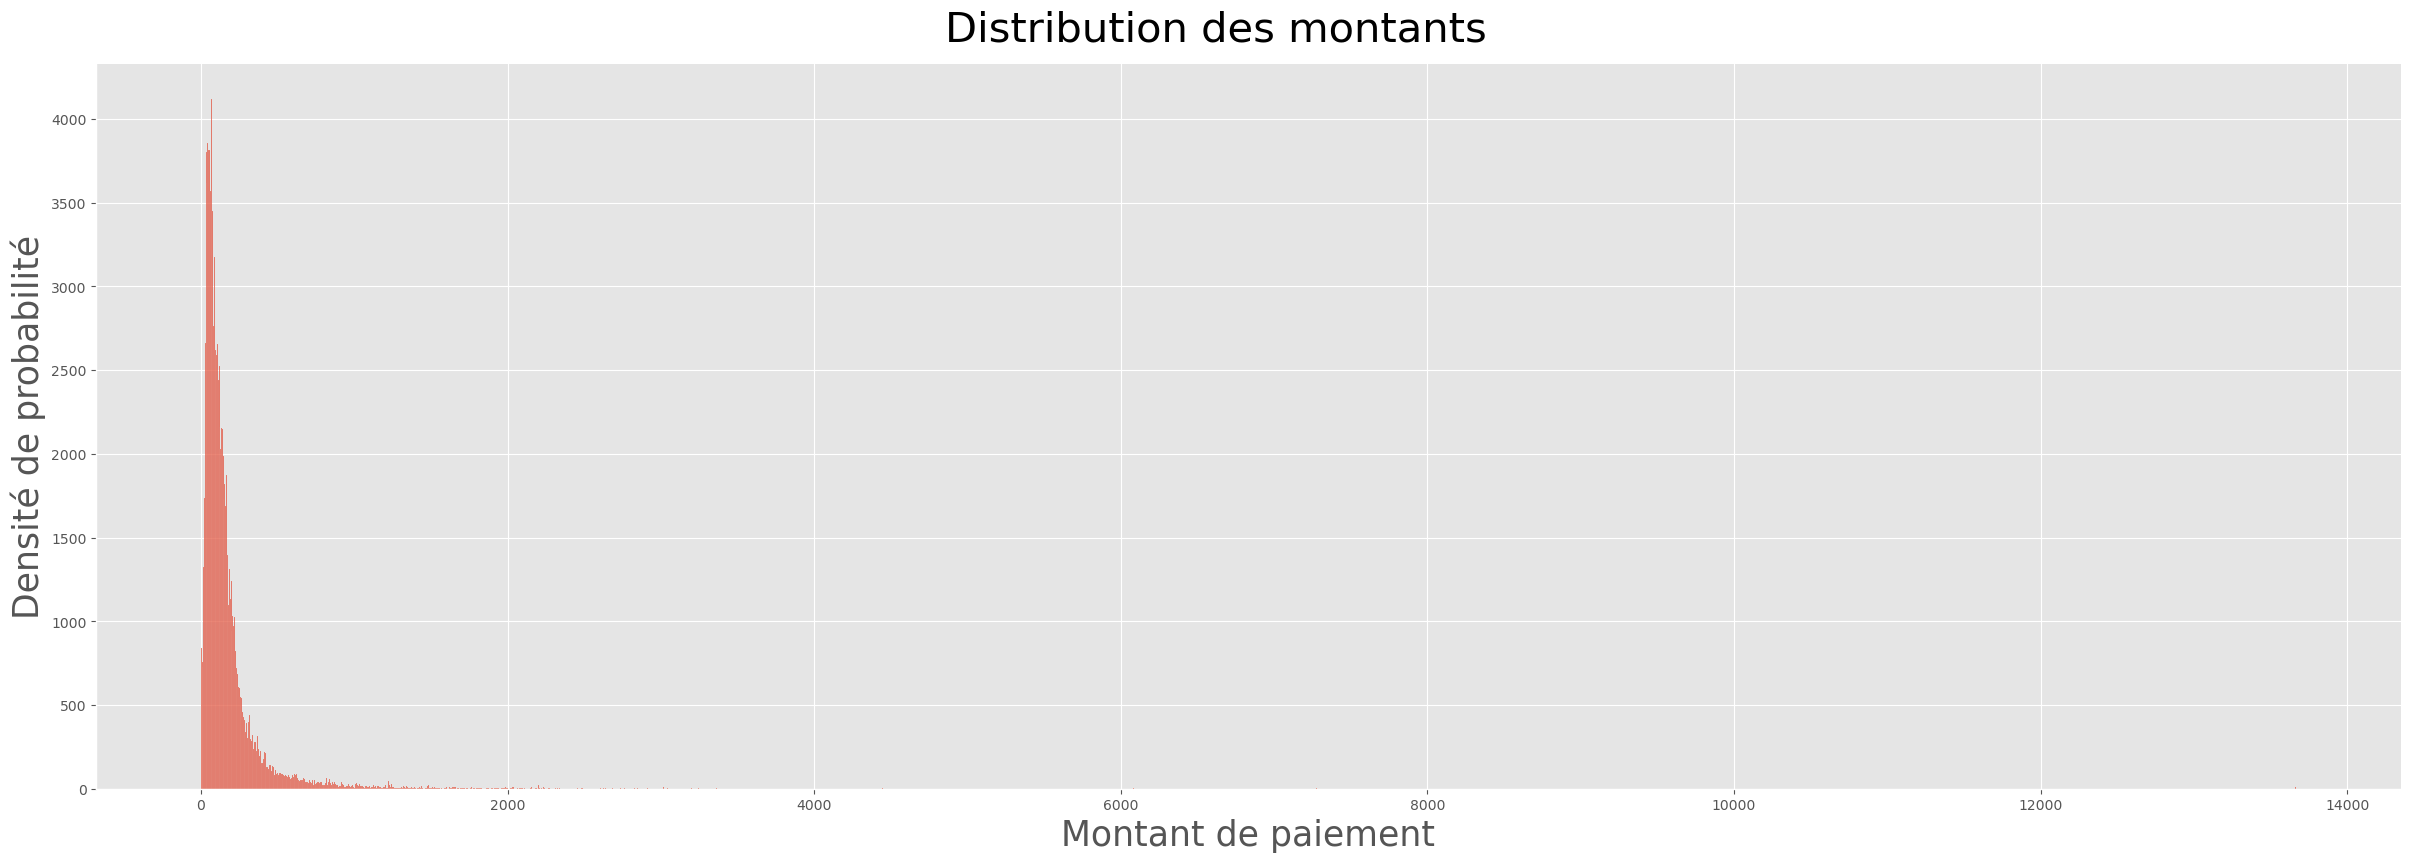

In [17]:
plot = sns.displot(data, x="payment_value", height=8, aspect=3)
plot.set_axis_labels("Montant de paiement", "Densité de probabilité")
plot.fig.suptitle("Distribution des montants", fontsize=30, y=1.05)
plot.ax.xaxis.label.set_size(25)
plot.ax.yaxis.label.set_size(25)
plt.show()

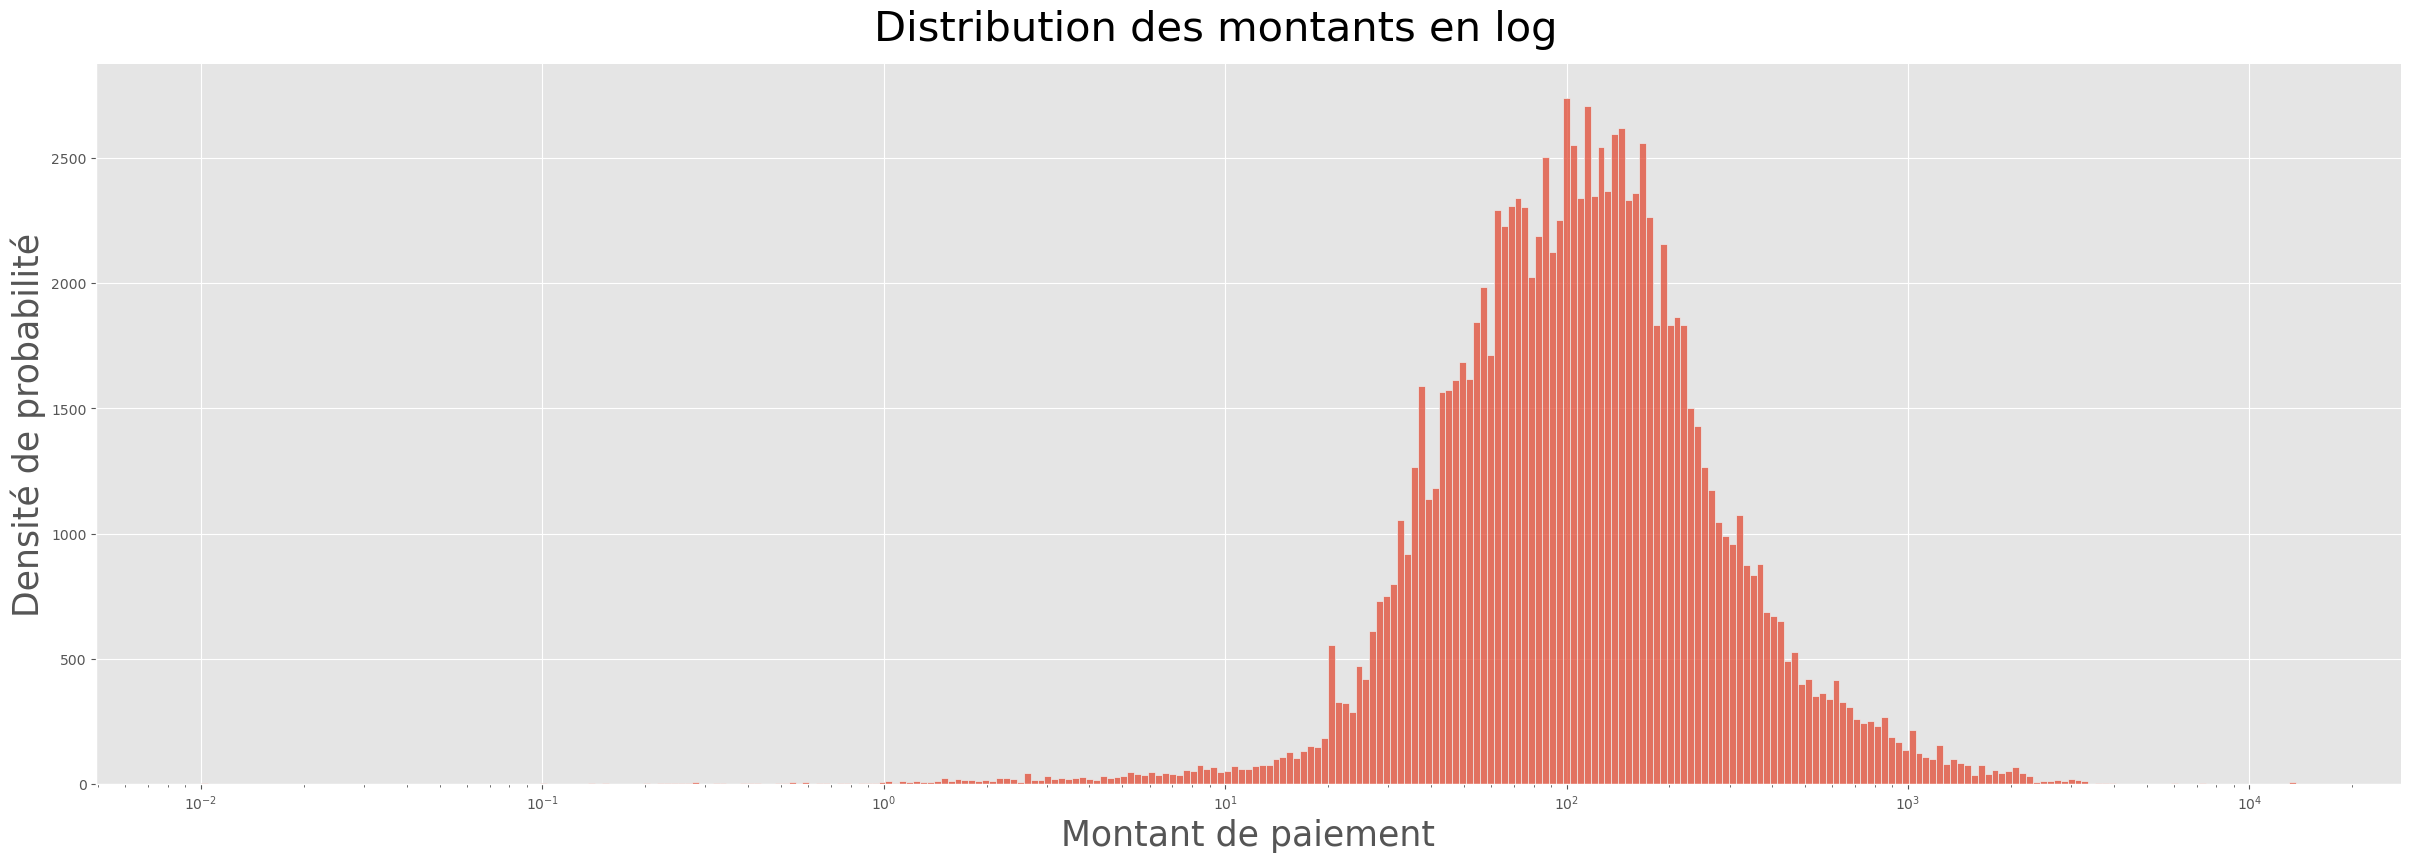

In [18]:
plot = sns.displot(data, x="payment_value", log_scale=True, height=8, aspect=3)
plot.set_axis_labels("Montant de paiement", "Densité de probabilité")
plot.fig.suptitle("Distribution des montants en log", fontsize=30, y=1.05)
plot.ax.xaxis.label.set_size(25)
plot.ax.yaxis.label.set_size(25)
plt.show()

## <font color="#114b98" id="section_2">2. Présentation de la segmentation RFM</font>

#### RFM est un acronyme pour Recence, Fréquence et Montant. 

- Récence : date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client. 


- Fréquence : nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.


- Montant : somme totale qu'un client dépense sur une période donnée

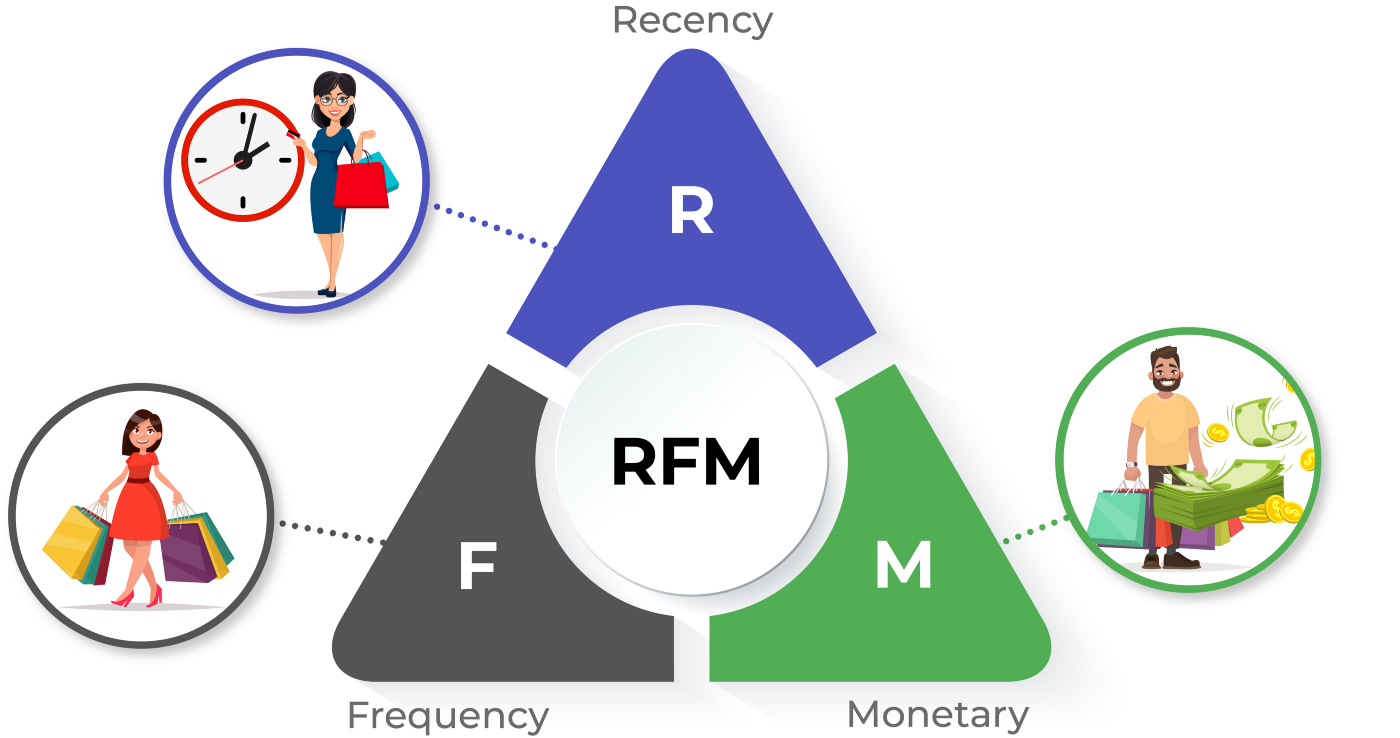

On s'intèresse tout d'abord à une période d'une année entière, soit 365 jours.

In [19]:
data["purchase_date"].max()

datetime.date(2018, 8, 29)

In [20]:
data["purchase_date"].min()

datetime.date(2016, 10, 3)

In [21]:
time = 365

In [22]:
today = data["purchase_date"].max() + dt.timedelta(days=1)
today

datetime.date(2018, 8, 30)

Je sélectionne uniquement les données disponibles sur les derniers 365 jours.

In [23]:
data_oneyear = data.loc[data["purchase_date"] >= (today - dt.timedelta(days=time))]

In [24]:
pd.options.mode.chained_assignment = None
data_oneyear.loc[:, "days_since_this_order"] = data_oneyear.loc[:, "purchase_date"].map(lambda d: (today - d).days)

In [25]:
data_oneyear

,id,payment_value,purchase_date,score,days_since_this_order
0,9ef432eb6251297304e76186b10a928d,18.12,2017-10-02,4,332
1,9ef432eb6251297304e76186b10a928d,2.00,2017-10-02,4,332
2,9ef432eb6251297304e76186b10a928d,18.59,2017-10-02,4,332
5,53904ddbea91e1e92b2b3f1d09a7af86,44.09,2017-10-23,3,311
18,856f3263eb7af3a48765c85d4d0eea1d,60.63,2017-09-26,3,338
...,...,...,...,...,...
114850,a0b67404d84a70ef420a7f99ad6b190a,93.13,2018-07-01,5,60
114851,d531d01affc2c55769f6b9ed410d8d3c,444.07,2018-07-24,5,37
114852,48ebd9467fef647e9a0cd9c1b9bdbe24,86.15,2018-01-11,5,231
114853,9d8c06734fde9823ace11a4b5929b5a7,244.02,2018-05-22,4,100


Je vérifie que la période est bien de 1 an.

In [26]:
data_oneyear['purchase_date'].min()

datetime.date(2017, 8, 30)

In [27]:
data_oneyear['purchase_date'].max()

datetime.date(2018, 8, 29)

In [28]:
data_oneyear[data_oneyear['id']=='00066ccbe787a588c52bd5ff404590e3']

,id,payment_value,purchase_date,score,days_since_this_order
37845,00066ccbe787a588c52bd5ff404590e3,270.0,2018-02-06,1,205
37846,00066ccbe787a588c52bd5ff404590e3,270.0,2018-02-06,1,205
37847,00066ccbe787a588c52bd5ff404590e3,270.0,2018-02-06,1,205
37848,00066ccbe787a588c52bd5ff404590e3,270.0,2018-02-06,1,205


Je calcule la récence, la fréquence et le montant total de chaque client.

In [29]:
aggr = {'days_since_this_order': lambda x: x.min(),   # Récence
        'purchase_date': lambda x: len(x),            # Frequence  
        'payment_value': lambda x: x.sum()}           # Montant

In [30]:
data_rfm = data_oneyear.groupby('id').agg(aggr).reset_index()

In [31]:
data_rfm.rename(columns={'days_since_this_order': 'Récence',
                         'purchase_date': 'Fréquence',
                         'payment_value': 'Montant'},
                inplace=True)

Je me retrouve avec un fichier client qui pour chaque observation indique la récence du dernier achat, la fréquence et le montant dépensé en un an.

In [32]:
data_rfm.head(10)

,id,Récence,Fréquence,Montant
0,00012a2ce6f8dcda20d059ce98491703,289,1,114.74
1,000379cdec625522490c315e70c7a9fb,150,1,107.01
2,000419c5494106c306a97b5635748086,181,1,49.40
3,00046a560d407e99b969756e0b10f282,255,1,166.59
4,00050bf6e01e69d5c0fd612f1bcfb69c,347,1,85.23
5,000598caf2ef4117407665ac33275130,19,1,1255.71
6,0005aefbb696d34b3424dccd0a0e9fd0,71,1,147.33
7,00066ccbe787a588c52bd5ff404590e3,205,4,1080.00
8,00072d033fe2e59061ae5c3aff1a2be5,363,1,106.97
9,000bf8121c3412d3057d32371c5d3395,323,2,91.12


Je prends l'opposé de la variable récence afin qu'un score élevé montre quelque chose de positif comme pour les deux autres variables.

In [33]:
data_rfm['Récence'] = time - data_rfm['Récence']

In [34]:
data_rfm_v1 = data_rfm.copy()

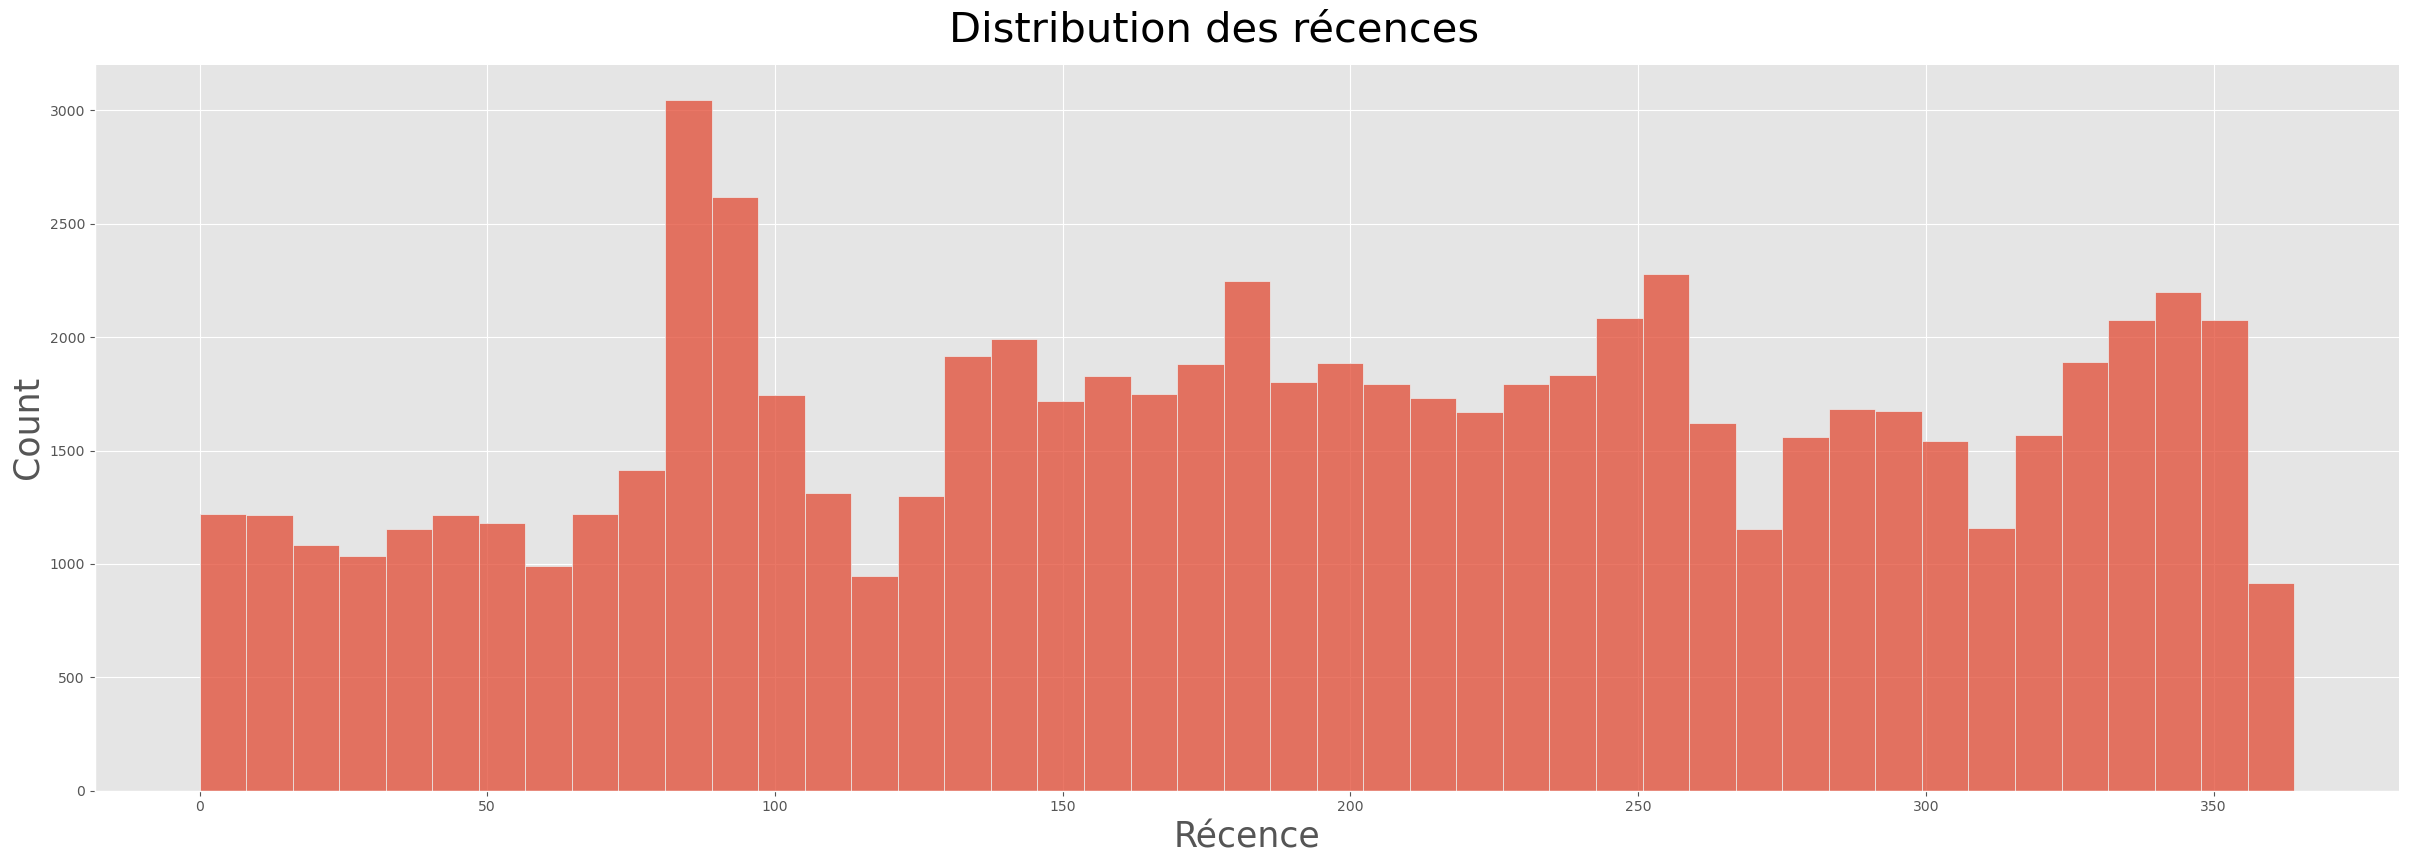

In [35]:
plot = sns.displot(data_rfm, x="Récence", height=8, aspect=3)
plot.set_axis_labels("Récence", "Count")
plot.fig.suptitle('Distribution des récences', fontsize=30, y=1.05)
plot.ax.xaxis.label.set_size(25)
plot.ax.yaxis.label.set_size(25)
plt.show()

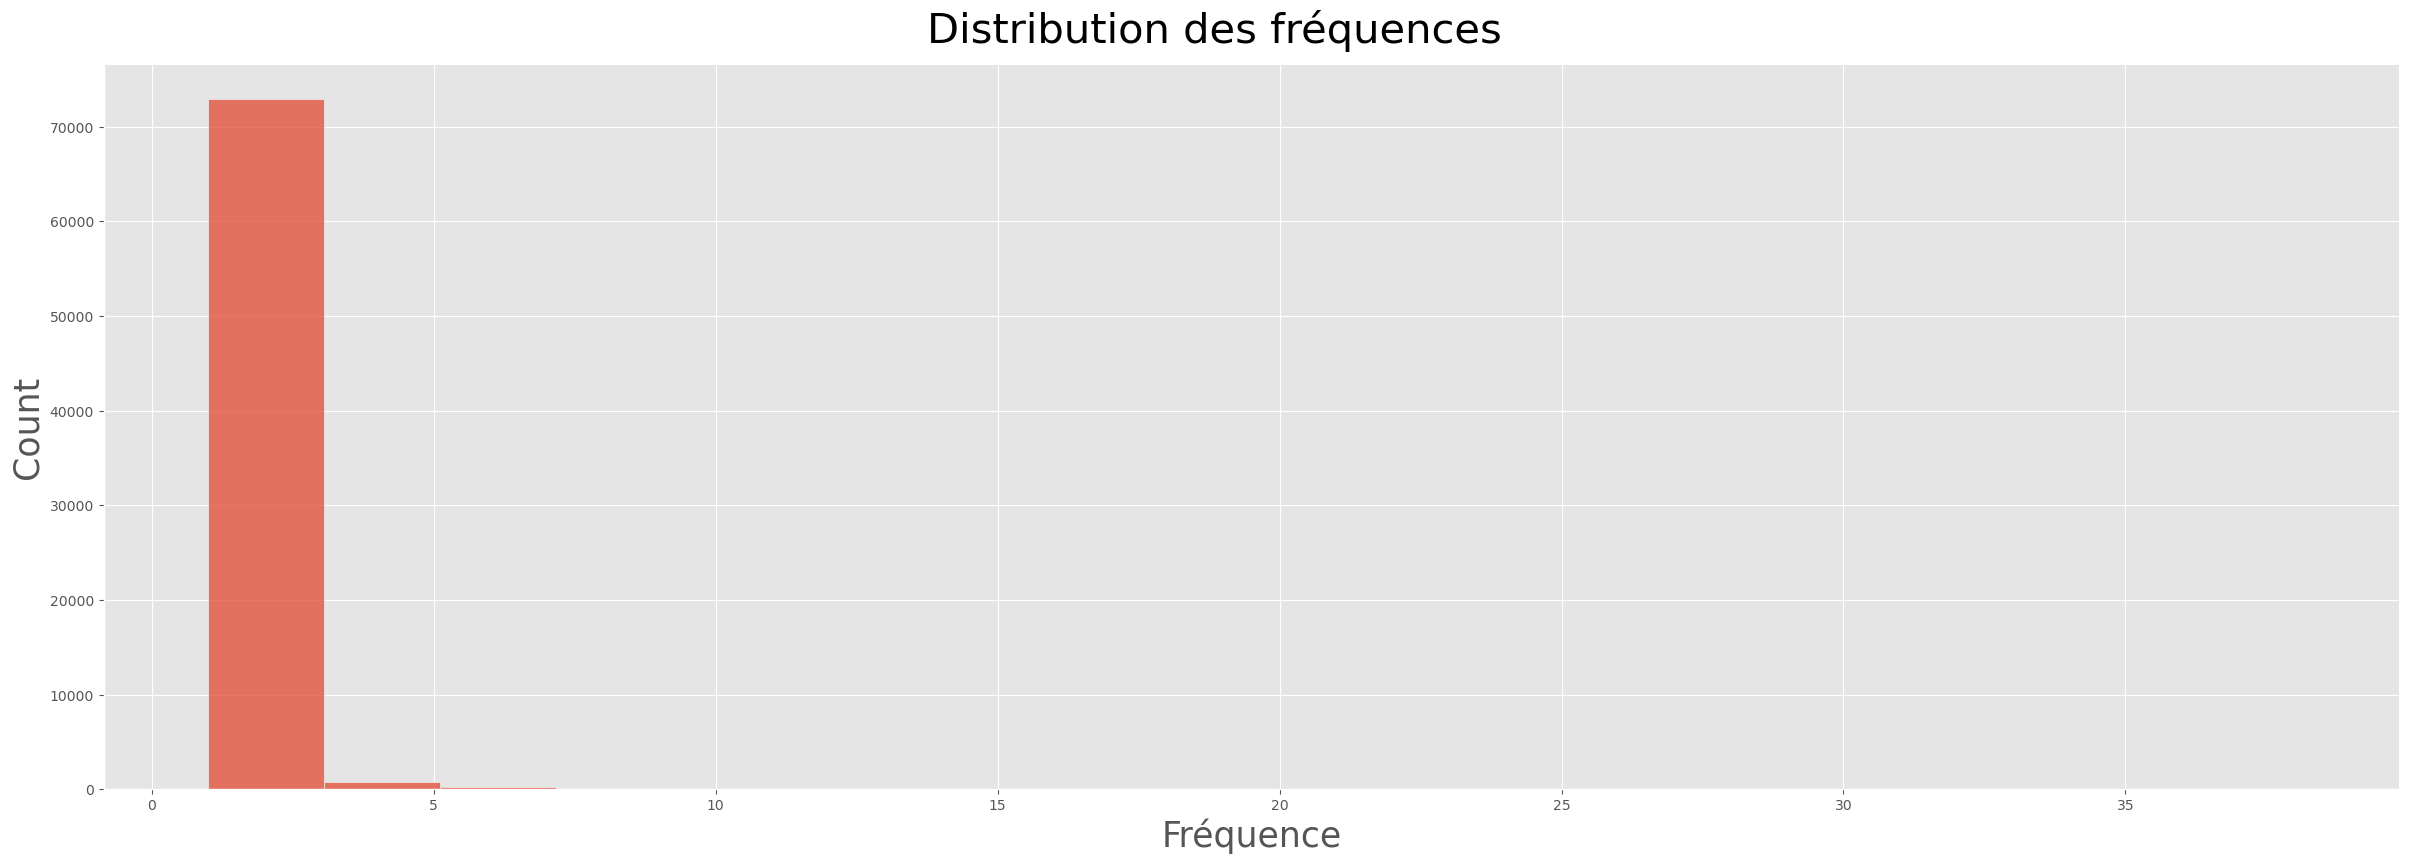

In [36]:
plot = sns.displot(data_rfm, x="Fréquence", height=8, aspect=3)
plot.set_axis_labels("Fréquence", "Count")
plot.fig.suptitle('Distribution des fréquences', fontsize=30, y=1.05)
plot.ax.xaxis.label.set_size(25)
plot.ax.yaxis.label.set_size(25)
plt.show()

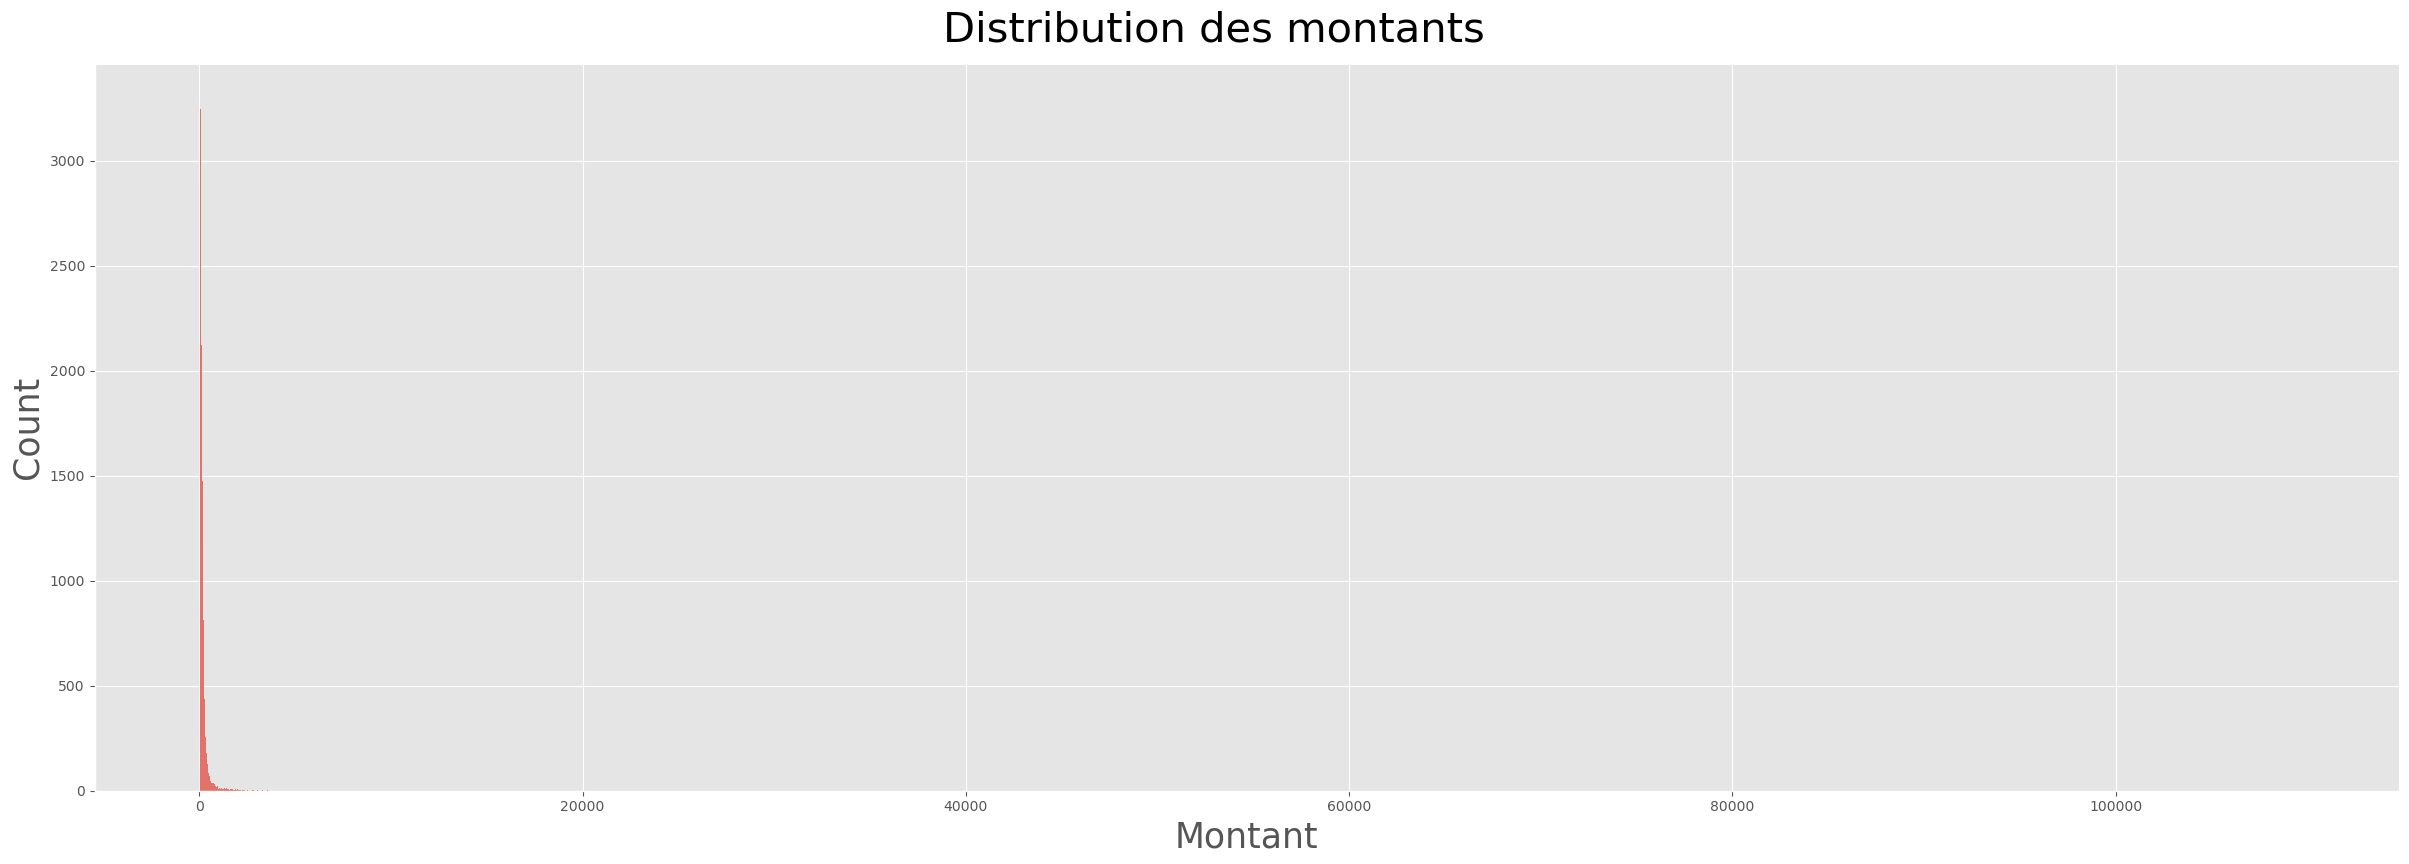

In [37]:
plot = sns.displot(data_rfm, x="Montant", height=8, aspect=3)
plot.set_axis_labels("Montant", "Count")
plot.fig.suptitle('Distribution des montants', fontsize=30, y=1.05)
plot.ax.xaxis.label.set_size(25)
plot.ax.yaxis.label.set_size(25)
plt.show()

Je décide de convertir avec la fonction logarithme les montants des paiements.

In [38]:
data_rfm['Montant'] = [log(p) for p in data_rfm['Montant']]

In [39]:
# data_rfm['Fréquence'] = [log(p) for p in data_rfm['Fréquence']]

In [40]:
data_rfm.shape

(74045, 4)

Il y a un total de 74045 clients dans ce jeu de données.

In [41]:
data_rfm.dtypes

id            object
Récence        int64
Fréquence      int64
Montant      float64
dtype: object

## <font color="#114b98" id="section_3">3. Segmentation par calculs statistiques</font>

Nous allons réaliser les étapes suivantes :
- Quartiliser chaque variable Récence, Fréquence et Montant et leur attribuer une note entre 1 et 4
- Segmenter des groupes d'individus en fonction de leurs notes pour chaque variable Récence, Fréquence et Montant
- Etiquetter chaque segment

Nous devons tout d'abord définir des catégories afin de répartir nos clients.

N'ayant pas de connaissance personnelle dans la segmentation des clients, je suis parti d'un article disponible avec le lien suivant :

Source : https://www.e-marketing.fr/Thematique/academie-1078/fiche-outils-10154/scoring-RFM-306775.htm

La combinaison des trois critères d'appréciation des clients permet de cibler neuf grands types de clients. 

- 1. Lost : clients perdus depuis longtemps (peu fréquents, a acheté il y a un moment)
- 2. Old : clients qui tendent à disparaitre (fréquence moyenne)
- 3. Risk : clients réguliers perdus récemment (dépensaient beaucoup, achetaient souvent mais il y a lomgtemps)
- 4. New : nouveau client (fréquence faible)
- 5. Recent : clients récents avec une fréquence faible
- 6. Promising : clients très réguliers et moyennement récents 
- 7. Loyal R$\$$- : clients réguliers à petites dépenses (achats récents, achète moyennement souvent et dépense peu)
- 8. Loyal R$\$$+: clients réguliers en développement (achats récents, achète moyennement souvent et dépense beaucoup)
- 9. Champions : très bons clients réguliers (achats récents, achète souvent et dépense beaucoup)

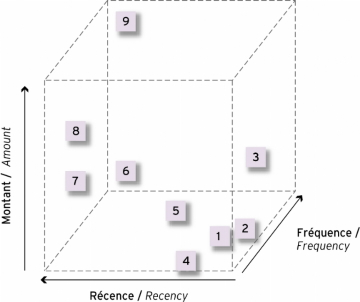

Afin de simplifier légèrement la segmentation, je décide de regrouper dans un même segment:
 - les clients 'Old', 'Risk' et 'Lost'
 - les clients 'Champions', 'Loyal R$\$$-', et 'Loyal R$\$$+'

In [42]:
cat = ["Champions",
       "Promising",
       "Recent",
       "New Clients",
       "Old Clients",
       "Others"]

In [43]:
data_rfm.head()

,id,Récence,Fréquence,Montant
0,00012a2ce6f8dcda20d059ce98491703,76,1,4.742669
1,000379cdec625522490c315e70c7a9fb,215,1,4.672922
2,000419c5494106c306a97b5635748086,184,1,3.899950
3,00046a560d407e99b969756e0b10f282,110,1,5.115536
4,00050bf6e01e69d5c0fd612f1bcfb69c,18,1,4.445353


Je décide de séparer les différentes variables par quartiles.

In [44]:
quartiles = data_rfm[['Récence', 'Fréquence', 'Montant']].quantile([.25, .5, .75]).to_dict()

In [45]:
def quartiles_score(x, quartiles, col):

    if x <= quartiles[col][.25]:
        return 1
    elif x <= quartiles[col][.5]:
        return 2
    elif x <= quartiles[col][.75]:
        return 3
    else:
        return 4

In [46]:
data_rfm_scores = pd.DataFrame()

In [47]:
data_rfm_scores['R'] = data_rfm['Récence'].apply(lambda x: quartiles_score(x, quartiles, 'Récence'))

In [48]:
data_rfm_scores['F'] = data_rfm['Fréquence'].apply(lambda x: quartiles_score(x, quartiles, 'Fréquence'))

In [49]:
data_rfm_scores['M'] = data_rfm['Montant'].apply(lambda x: quartiles_score(x, quartiles, 'Montant'))

In [50]:
data_rfm_scores.head()

,R,F,M
0,1,1,3
1,3,1,2
2,2,1,1
3,2,1,3
4,1,1,2


Je vais visualiser les clients sur différents graphiques afin de bien comprendre leur répartition.

Voici un graphique vierge que je vais utiliser :
- les fréquences sont en abscisses
- les récences sont en ordonnées
- les montants sont sur la hauteur du cube

Le plus simple serait de le visualiser en 3D comme un cube 4x4x4 que je projette à plat ci-dessous.

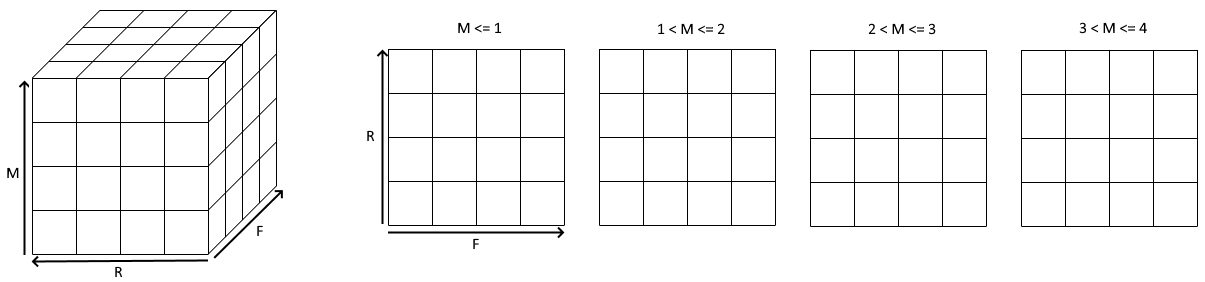

### Champions 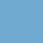

Très bons clients réguliers (achats récents, achète souvent et dépense beaucoup)

R > 2 ; F > 2

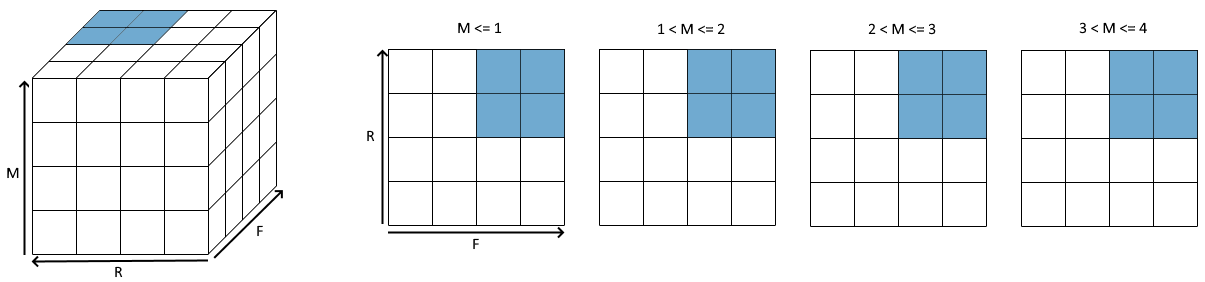

### Promising 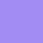

Clients très réguliers et moyennement récents 

R > 1 ; F > 2 ; M > 2

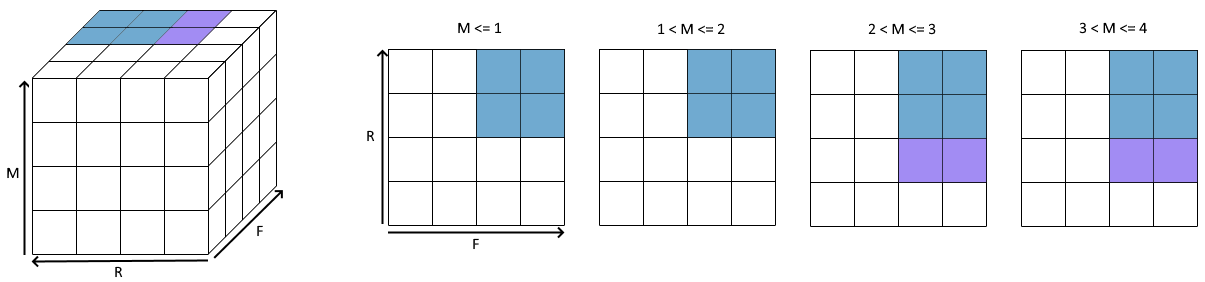

### New Clients 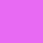

Nouveaux clients

R = 4 ; F < 3 

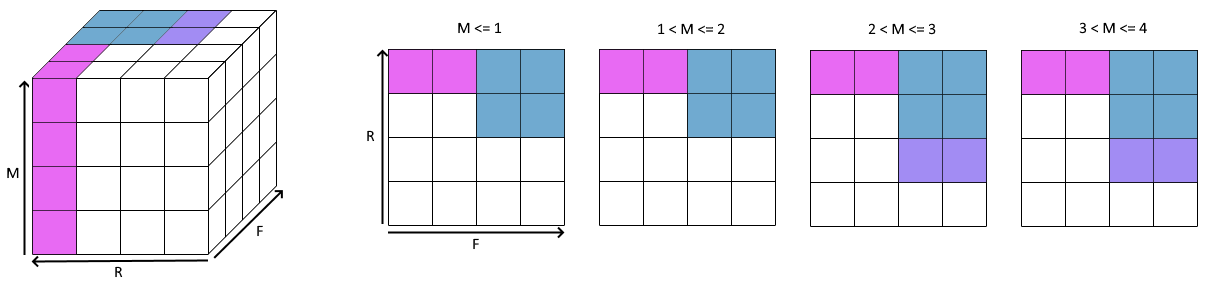

### Recent 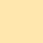

Clients récents avec une faible fréquence

R = 3 ; F < 3

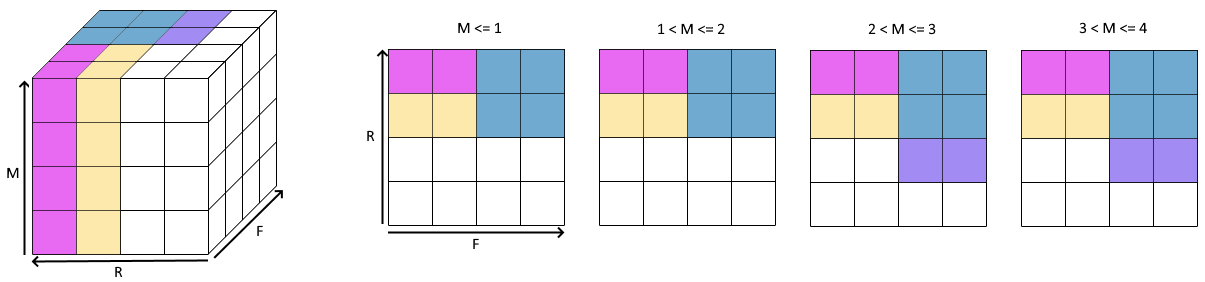

### Old Clients 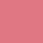

Clients qui tendent à disparaitre ou perdus depuis longtemps

R = 1

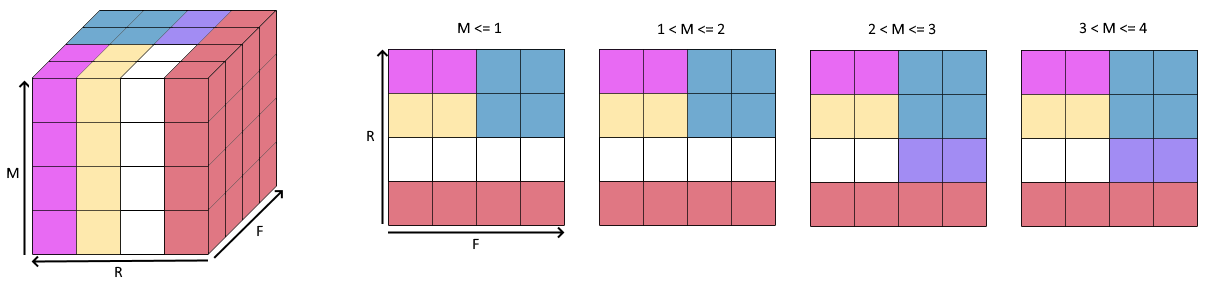

### Others 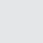

Clients non catégorisés

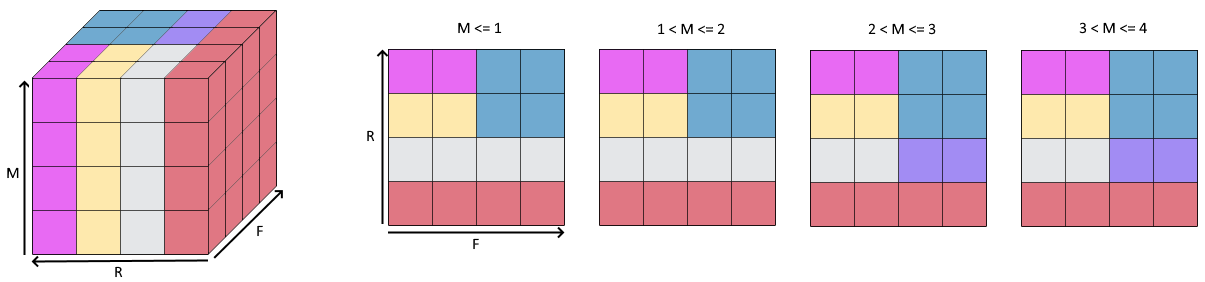

Je crée une fonction permettant d'affecter chaque client à son segment.

In [51]:
def segments(rfm):
    """
    Retourne le segment associé au client en fonction
    de son score pour les variables R, F et M

    """

    if rfm["R"] >= 3 and rfm["F"] >= 3 :
        return "Champions"

    elif rfm["R"] >= 2 and rfm["F"] >= 3:
        return "Promising"

    elif rfm["R"] == 3 and rfm["F"] < 3:
        return "Recent"

    elif rfm["R"] == 4 and rfm["F"] < 3:
        return "New Clients"

    elif rfm["R"] == 1 :
        return "Old Clients"
    
    else:
        return "Others"

Je calcule maintenant les différentes catégories.

In [52]:
data_rfm_scores["clusters_stats"] = data_rfm_scores.apply(segments, axis=1)

In [53]:
data_rfm_scores.head(10)

,R,F,M,clusters_stats
0,1,1,3,Old Clients
1,3,1,2,Recent
2,2,1,1,Others
3,2,1,3,Others
4,1,1,2,Old Clients
5,4,1,4,New Clients
6,4,1,3,New Clients
7,2,4,4,Promising
8,1,1,2,Old Clients
9,1,4,2,Old Clients


In [54]:
data_rfm_scores.shape

(74045, 4)

In [55]:
data_segmentation = data_rfm.join(data_rfm_scores)

In [56]:
data_segmentation.head(10)

,id,Récence,Fréquence,Montant,R,F,M,clusters_stats
0,00012a2ce6f8dcda20d059ce98491703,76,1,4.742669,1,1,3,Old Clients
1,000379cdec625522490c315e70c7a9fb,215,1,4.672922,3,1,2,Recent
2,000419c5494106c306a97b5635748086,184,1,3.899950,2,1,1,Others
3,00046a560d407e99b969756e0b10f282,110,1,5.115536,2,1,3,Others
4,00050bf6e01e69d5c0fd612f1bcfb69c,18,1,4.445353,1,1,2,Old Clients
5,000598caf2ef4117407665ac33275130,346,1,7.135456,4,1,4,New Clients
6,0005aefbb696d34b3424dccd0a0e9fd0,294,1,4.992675,4,1,3,New Clients
7,00066ccbe787a588c52bd5ff404590e3,160,4,6.984716,2,4,4,Promising
8,00072d033fe2e59061ae5c3aff1a2be5,2,1,4.672548,1,1,2,Old Clients
9,000bf8121c3412d3057d32371c5d3395,42,2,4.512177,1,4,2,Old Clients


In [57]:
data_segmentation.groupby(['clusters_stats'])[['Récence',
                                               'Fréquence',
                                               'Montant']].agg(['count',
                                                                'min',
                                                                'mean',
                                                                'median',
                                                                'max'])

Récence                              Fréquence                \
                 count  min        mean median  max     count min      mean   
clusters_stats                                                                
Champions         4605  191  272.885559  268.0  364      4605   2  2.504452   
New Clients      16165  276  320.379709  324.0  364     16165   1  1.000000   
Old Clients      18689    0   59.616887   66.0  103     18689   1  1.213816   
Others           15986  104  150.474353  151.0  190     15986   1  1.000000   
Promising         2366  104  151.149620  152.0  190      2366   2  2.467878   
Recent           16234  191  231.885549  232.0  275     16234   1  1.000000   

                          Montant                                           
               median max   count       min      mean    median        max  
clusters_stats                                                              
Champions         2.0  24    4605  2.260721  5.781645  5.759406  10.315134  
New Clients       1.0   1   16165  2.387845  4.646168  4.611152   8.451434  
Old Clients       1.0  38   18689  2.309561  4.797941  4.698387  11.601967  
Others            1.0   1   15986  2.623218  4.607099  4.585274   8.249784  
Promising         2.0  24    2366  2.795450  5.713270  5.704715  10.693035  
Recent            1.0   1   16234  2.516890  4.657131  4.621437   8.336932

In [58]:
my_palette = {"Champions": '#70AAD0',
              "New Clients": '#E86AF3',
              "Old Clients": '#E07783',
              "Others": '#E4E6E8',
              "Promising": '#A28CF3',
              "Recent": '#FEE9AD'}

In [59]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [60]:
from sklearn.preprocessing import StandardScaler

In [61]:
def boxplots_segments(key, data, group_by, title, color):
   
    df_stdsca = pd.DataFrame(StandardScaler().fit_transform(data[['Récence','Fréquence','Montant']]),
                             columns=list(data[['Récence','Fréquence','Montant']].columns),
                             index=data.index)
    
        
    df_temp = df_stdsca.join(data[group_by])
    sns.boxplot(data=df_temp[df_temp.loc[:,group_by]==key].drop(group_by, axis=1), showfliers=False, color=color) 

    plt.title(title, size=18, color='black', y=1.05)

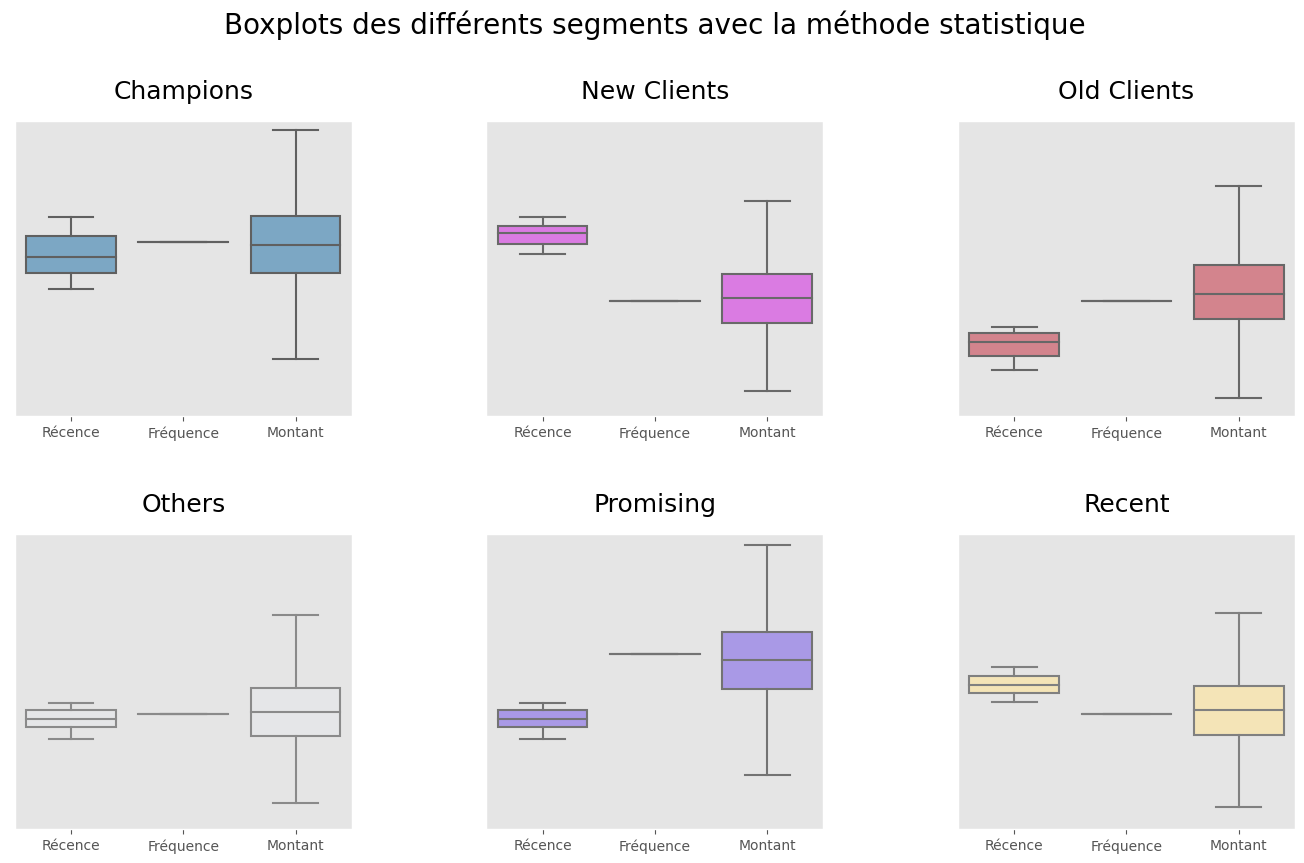

In [62]:
# Création de la figure avec une taille spécifique
plt.figure(figsize=(16, 14))
# Ajout du titre de la figure
plt.suptitle('Boxplots des différents segments avec la méthode statistique', size=20, y=0.98)
# Initialisation d'un compteur pour l'index de la sous-trame
i = 1
# Itéreration sur les clés et les valeurs dans le dictionnaire my_palette
for key, value in my_palette.items():
    # Création de la sous-trame
    ax = plt.subplot(3, 3, i)
    # Ajustement de l'espacement entre les sous-trames
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.ylim(-3, 4)
    plt.yticks([], [])
    # Incrémentation de l'index de la sous-trame
    i += 1

    # Création du boxplot
    boxplots_segments(key=key,
                      data=data_segmentation.drop('id', axis=1),
                      group_by='clusters_stats',
                      title=key,
                      color=value)

In [63]:
def plot_column(column, key, my_palette):
    # Création de la figure avec une taille spécifique
    plt.figure(figsize=(16, 4))
    # Ajout du titre de la figure
    plt.suptitle(f'Boxplots des différents {key} pour la variable {column}', size=18, y=1.01)
    plt.yticks([], [])
    # Création du boxplot
    sns.boxplot(data=data_segmentation, x=key, y=column, showfliers=False,
                order=list(my_palette.keys()),
                palette=list(my_palette.values()))

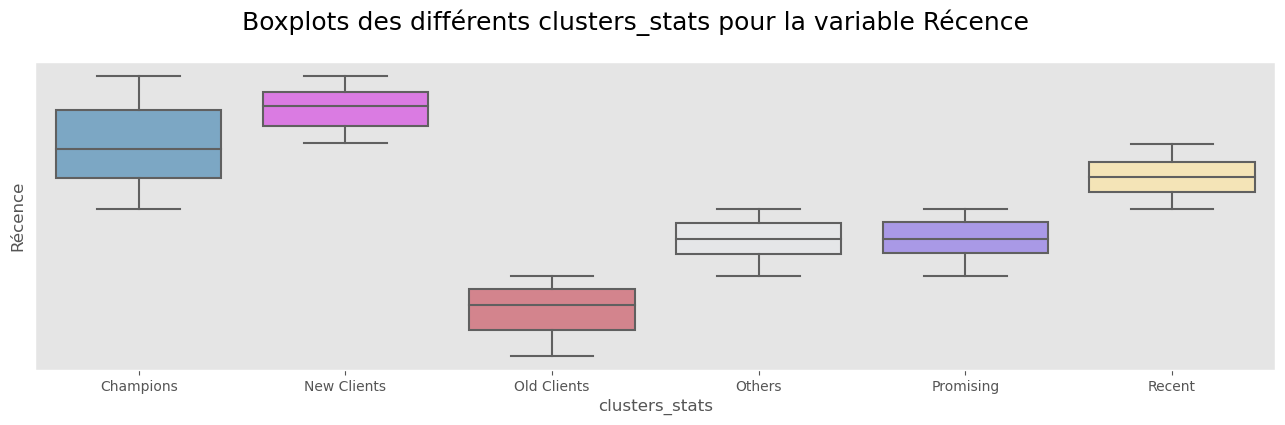

In [64]:
plot_column('Récence', 'clusters_stats', my_palette)

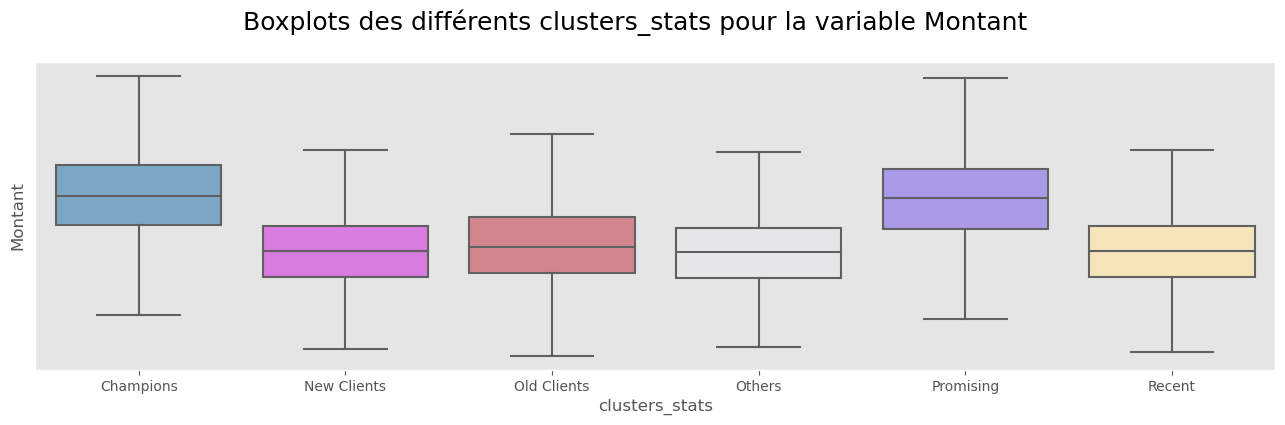

In [65]:
plot_column('Montant', 'clusters_stats', my_palette)

In [66]:
def projection_2d_segments(df, df2, xlabel, ylabel, label_score, colors):

    temp_df = pd.merge(df[['id', label_score]], df2, on='id')

    # Itération sur les valeurs uniques de la colonne label_score
    for segment in temp_df[label_score].unique():
        # Sélectio des lignes où la valeur de label_score est égale au segment actuel
        segment_data = temp_df[temp_df[label_score] == segment]
        # Trace des valeurs x et y de ces lignes comme un graphique de dispersion
        plt.scatter(segment_data[xlabel], 
                    segment_data[ylabel],
                    label=segment, 
                    c=colors[segment])

    # Définition des étiquettes des axes x et y
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

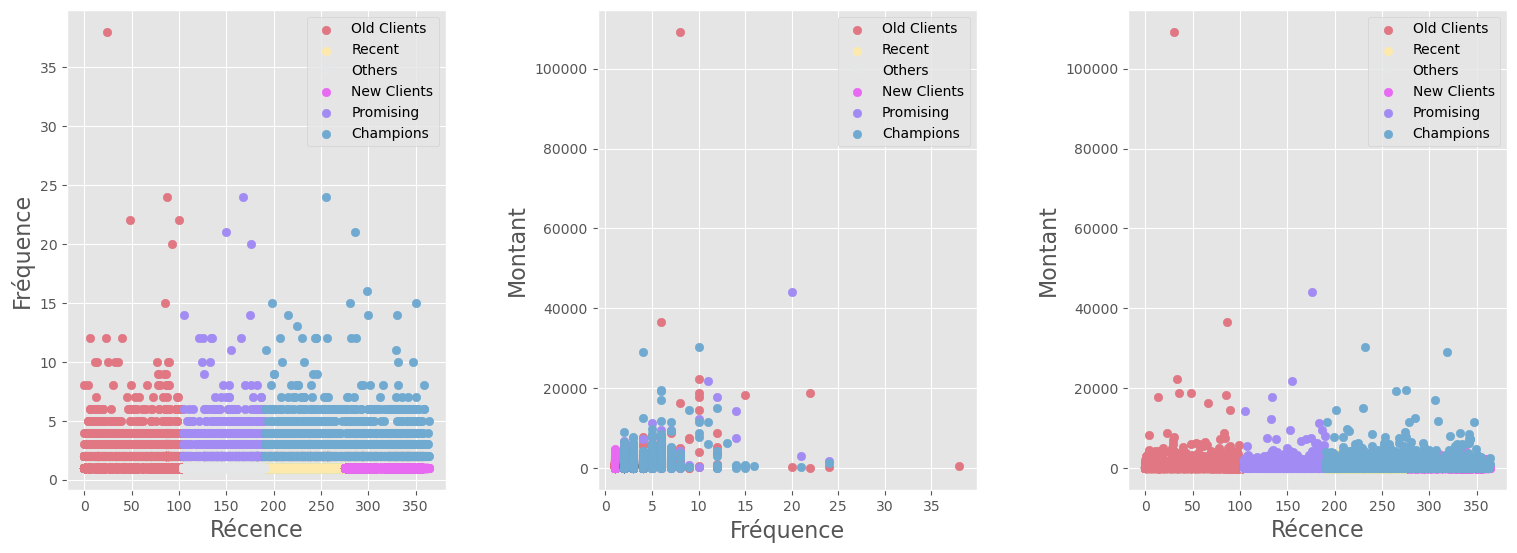

In [67]:
plt.figure(1, figsize=(18, 6))

plt.subplot(1, 3, 1)
projection_2d_segments(data_segmentation,
                       data_rfm_v1,
                       "Récence",
                       "Fréquence",
                       "clusters_stats",
                       my_palette)
plt.legend()
plt.subplot(1, 3, 2)
projection_2d_segments(data_segmentation,
                       data_rfm_v1,
                       "Fréquence",
                       "Montant",
                       "clusters_stats",
                       my_palette)
plt.legend()
plt.subplot(1, 3, 3)
projection_2d_segments(data_segmentation,
                       data_rfm_v1,
                       "Récence",
                       "Montant",
                       "clusters_stats",
                       my_palette)
plt.legend()
# Espacement entre les différents subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

Nous allons maintenant visualiser  en 3D les différents clients associés à leurs catégories.

In [68]:
def projection_3d_segments(df, label_score, colors, aspect):
    fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={"projection": "3d"})
    ax.set_box_aspect(aspect=aspect)

    for segment, color in colors.items():
        mask = df[label_score] == segment
        ax.scatter(df[mask]['Récence'], df[mask]['Fréquence'], df[mask]['Montant'], label=segment, s=80, c=color)

    ax.invert_xaxis()
    ax.set_xlabel("Récence")
    ax.set_ylabel("Fréquence")
    ax.set_zlabel("Montant")
    ax.set_facecolor("white")
    ax.set_title("Représentation 3D des différents individus", size=15, y=1.1)
    ax.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

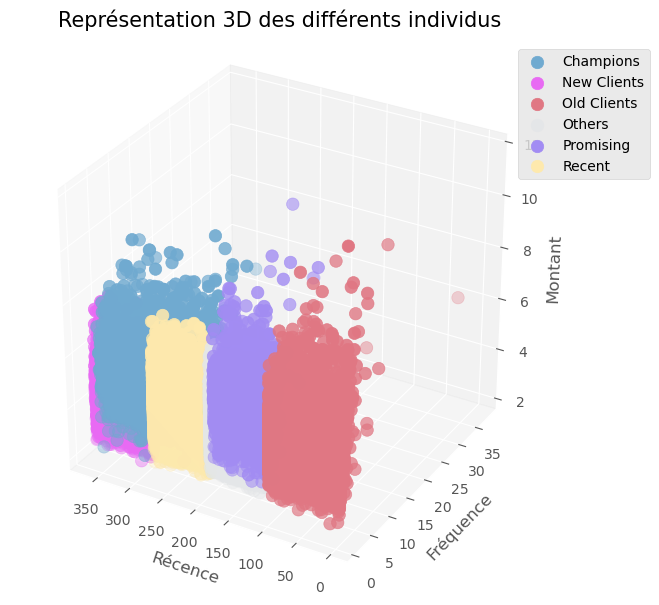

In [69]:
# Graphique 3D
projection_3d_segments(data_segmentation, 'clusters_stats', my_palette, (1, 1, 1))

In [70]:
data_merge_segments = data_segmentation.merge(data, left_on='id', right_on='id')

In [71]:
data_merge_segments.head()

,id,Récence,Fréquence,Montant,R,F,M,clusters_stats,payment_value,purchase_date,score
0,00012a2ce6f8dcda20d059ce98491703,76,1,4.742669,1,1,3,Old Clients,114.74,2017-11-14,1
1,000379cdec625522490c315e70c7a9fb,215,1,4.672922,3,1,2,Recent,107.01,2018-04-02,4
2,000419c5494106c306a97b5635748086,184,1,3.899950,2,1,1,Others,49.40,2018-03-02,1
3,00046a560d407e99b969756e0b10f282,110,1,5.115536,2,1,3,Others,166.59,2017-12-18,5
4,00050bf6e01e69d5c0fd612f1bcfb69c,18,1,4.445353,1,1,2,Old Clients,85.23,2017-09-17,5


## <font color="#114b98" id="section_4">4. Segmentation RFM par algorithme non supervisé : KMEANS</font>

Nous allons réaliser les étapes suivantes :
- Normaliser les variables Récence, Fréquence et Montant
- Utiliser un algorithme de clusterisation sur ces données
- Etiquetter chaque cluster

In [72]:
data_rfm.head()

,id,Récence,Fréquence,Montant
0,00012a2ce6f8dcda20d059ce98491703,76,1,4.742669
1,000379cdec625522490c315e70c7a9fb,215,1,4.672922
2,000419c5494106c306a97b5635748086,184,1,3.899950
3,00046a560d407e99b969756e0b10f282,110,1,5.115536
4,00050bf6e01e69d5c0fd612f1bcfb69c,18,1,4.445353


In [73]:
data_rfm.shape

(74045, 4)

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score

In [75]:
def evaluate_clustering(data, algorithm, min_clusters, max_clusters):
    # Mettre les données à l'échelle pour les normaliser
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Créer un graphique elbow pour les scores d'elbow en utilisant Yellowbrick
    model = algorithm(random_state=44)
    elbow_visualizer = KElbowVisualizer(model, k=(min_clusters, max_clusters), 
                                        metric='calinski_harabasz', timings=False, size=(1150, 520))
    elbow_visualizer.fit(data_scaled)
    elbow_visualizer.show()

    # Créer 3 graphiques à barres pour les scores de stabilité, d'elbow et de silhouette
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    stability_scores_cls = []
    elbow_scores = []
    silhouette_score_avg = []
    for n_cls in range(min_clusters, max_clusters+1):
        model = algorithm(n_clusters=n_cls)
        labels = model.fit_predict(data_scaled)
        elbow_scores.append(model.inertia_)
        silhouette_score_avg.append(silhouette_score(data_scaled, labels))
        n_runs = 10
        stability_scores = []
        for i in range(n_runs):
            model = algorithm(n_clusters=n_cls)
            labels_i = model.fit_predict(data_scaled)
            stability_scores.append(adjusted_rand_score(labels, labels_i))
        stability_scores_cls.append(np.mean(stability_scores))
    ax1.bar(range(min_clusters, max_clusters + 1), stability_scores_cls)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Stability score')
    ax2.plot(range(min_clusters, max_clusters + 1), elbow_scores)
    ax2.set_title('Elbow graph')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia')
    ax3.bar(range(min_clusters, max_clusters + 1), silhouette_score_avg)
    ax3.set_ylabel("Silhouette Score")
    ax3.set_xlabel('Number of clusters')
    ax3.set_title("Silhouette graph")
    plt.show()

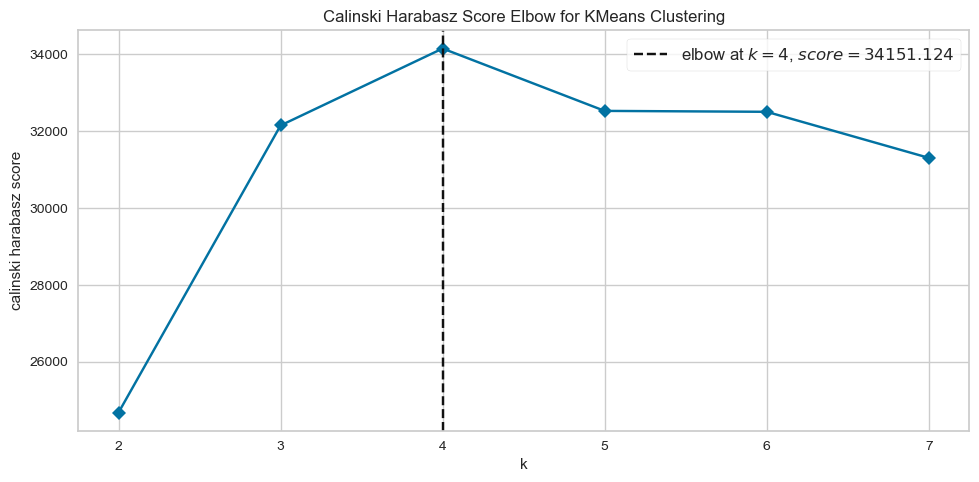

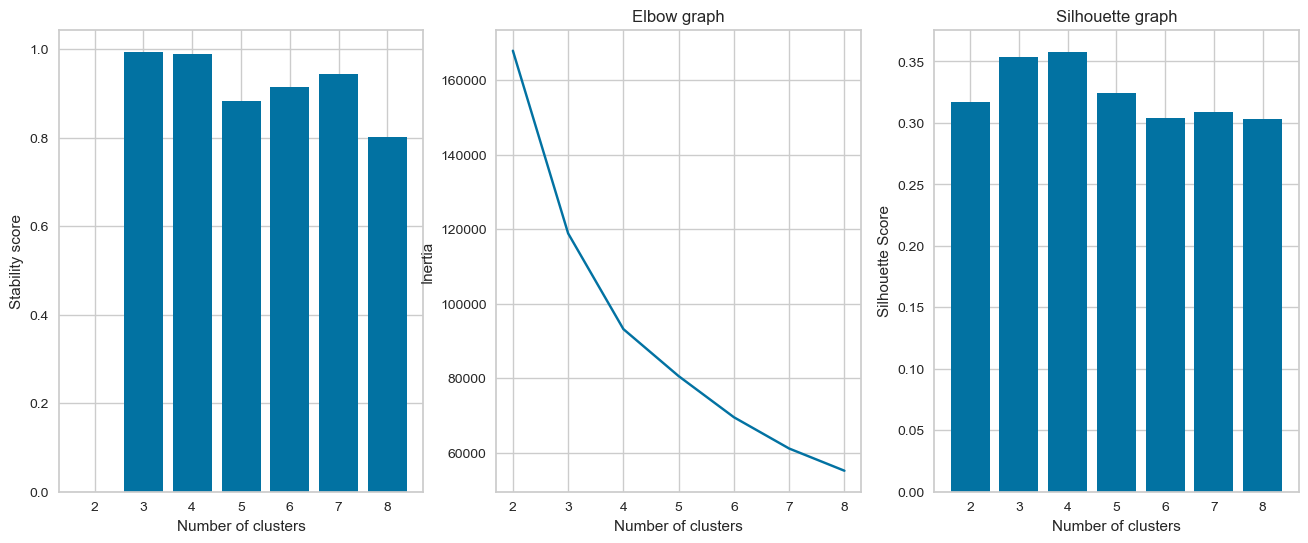

In [76]:
evaluate_clustering(data_rfm.drop('id', axis=1), KMeans, 2, 8)

Conclusions :
 - Le scoring par Calinski Harabasz de Yellowbrick indique un k = 4
 - La stabilité est très forte pour 2, 3, 4 clusters
 - Le graphique Elbow montre un coude pour 4 clusters
 - Le silhouette score est élevé pour 2, 3 et 4 clusters

Pour ces raisons, je choisis de définir le nombre de clusters idéal à 4.

In [77]:
from sklearn.metrics import silhouette_samples

In [78]:
def draw_silhouette(data, algorithm, number_of_clusters):

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)    
    model = algorithm(n_clusters=number_of_clusters)
    visualizer = SilhouetteVisualizer(model, size=(1150, 520))
    visualizer.fit(data_scaled)
    silhouette_values = silhouette_samples(data_scaled, visualizer.predict(data_scaled))
    print(f'Score de silhouette avec {algorithm} et {number_of_clusters} clusters :', silhouette_values.mean())
    visualizer.show()

In [ ]:
draw_silhouette(data_rfm.drop('id', axis=1), KMeans, 4)

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=99)

In [ ]:
data_rfm_scaled = StandardScaler().fit_transform(data_rfm.drop('id', axis=1))

In [ ]:
clusters = kmeans.fit_predict(data_rfm_scaled)
data_segmentation['clusters_kmeans'] = clusters

In [ ]:
data_segmentation.head()

Je regroupe mes données par cluster.

In [ ]:
data_segmentation.groupby(['clusters_kmeans'])[['Récence',
                                                'Fréquence',
                                                'Montant']].agg(['count',
                                                                 'min',
                                                                 'mean',
                                                                 'median',
                                                                 'max'])

J'étiquette chacun de ces clusters.

In [ ]:
cat_2 = ["New Clients",
         "Old Clients",
         "Promising",
         "Champions"]

In [ ]:
for index, cat in enumerate(cat_2):
    data_segmentation.loc[data_segmentation["clusters_kmeans"] == index, "clusters"] = cat

In [ ]:
func = ['count', 'min', 'median', 'max']
temp = data_segmentation.groupby(['clusters_kmeans'])
summery_table = temp[['Récence', 'Fréquence', 'Montant']].agg(func)

summery_table.reindex(cat_2)

In [ ]:
my_palette_2 = {"Champions": '#70AAD0',
                'Promising': '#A28CF3',
                "Old Clients": '#E07783',
                "New Clients": '#E86AF3'}

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Boxplots des différents clusters avec KMeans', size=20, y=0.98)
i=1

for key, value in my_palette_2.items():
    ax = plt.subplot(2, 2, i)
    plt.subplots_adjust(bottom=0.1,
                        top=0.85,
                        hspace=0.4)
    i += 1
    plt.ylim(-3, 10)
    plt.yticks([], [])
    boxplots_segments(key=key,
                          data=data_segmentation,
                          group_by='clusters_kmeans',
                          title=key,
                          color=value)

In [ ]:
plot_column('Montant', 'clusters_kmeans', my_palette_2)

In [ ]:
plot_column('Récence', 'clusters_kmeans', my_palette_2)

In [ ]:
plot_column('Fréquence', 'clusters_kmeans', my_palette_2)

In [ ]:
data_segmentation.head()

In [ ]:
projection_3d_segments(data_segmentation, 'clusters_kmeans', my_palette_2, (1, 1, 1))

## <font color="#114b98" id="section_5">5. Segmentation RFM par algorithme non supervisé : MINI BATCH KMEANS</font>

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
evaluate_clustering(data_rfm.drop('id', axis=1), MiniBatchKMeans, 2, 8)

Conclusions :
 - Le scoring par Calinski Harabasz de Yellowbrick indique un k = 4
 - La stabilité est très forte pour 4 clusters
 - Le graphique Elbow montre des coudes pour 4 clusters
 - Le silhouette score est élevé pour 4 clusters

Pour ces raisons, je choisis de définir le nombre de clusters idéal à 4.

In [ ]:
draw_silhouette(data_rfm.drop('id', axis=1), MiniBatchKMeans, 4)

In [ ]:
kmeans_mb = MiniBatchKMeans(n_clusters=4, init='k-means++', random_state=0)

In [ ]:
clusters_mb = kmeans_mb.fit_predict(data_rfm_scaled)
data_segmentation['clusters_mbkmeans'] = clusters_mb

In [ ]:
data_segmentation.head()

Résumé des résultats

In [ ]:
data_segmentation.groupby(['clusters_mbkmeans'])[['Récence',
                                                  'Fréquence',
                                                  'Montant']].agg(['count',
                                                                   'min',
                                                                   'mean',
                                                                   'median',
                                                                   'max'])

In [ ]:
cat_3 = ["New Clients",
         "Old Clients",
         "Champions",
         'Promising']

In [ ]:
for index, cat in enumerate(cat_3):
    data_segmentation.loc[data_segmentation["clusters_mbkmeans"] == index, "clusters_mbkmeans"] = cat

In [ ]:
func = ['count', 'min', 'median', 'max']
temp = data_segmentation.groupby(['clusters_mbkmeans'])
summery_table = temp[['Récence', 'Fréquence', 'Montant']].agg(func)

summery_table.reindex(cat_3)

In [ ]:
my_palette_3 = {"Champions": '#70AAD0',
                'Promising': '#A28CF3',
                "Old Clients": '#E07783',
                "New Clients": '#E86AF3'}

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Boxplots des différents clusters avec Mini Batch KMeans', size=20, y=0.98)
i = 1

for key, value in my_palette_3.items():
    ax = plt.subplot(2, 2, i)
    plt.subplots_adjust(bottom=0.1,
                        top=0.85,
                        hspace=0.4)
    i += 1
    plt.ylim(-3, 10)
    plt.yticks([], [])
    boxplots_segments(key=key,
                          data=data_segmentation,
                          group_by='clusters_mbkmeans',
                          title=key,
                          color=value)

In [ ]:
plot_column('Montant', 'clusters_mbkmeans', my_palette_3)

In [ ]:
plot_column('Récence', 'clusters_mbkmeans', my_palette_3)

In [ ]:
projection_3d_segments(data_segmentation, 'clusters_mbkmeans', my_palette_3, (1, 1, 1))

Les autres algorithmes testés dans ce projet (DBSCAN, MeanShift, ...) segmentent principalement selon un axe sur les 3 possibles.

## <font color="#114b98" id="section_6">6. Segmentation avec davantage de paramètres</font>

In [ ]:
data.head()

In [ ]:
data_plus = data[['id',
                  'payment_value',
                  'purchase_date',
                  'score']]

In [ ]:
data_plus.dtypes

In [ ]:
data_plus.shape

In [ ]:
data_plus['purchase_date'] = data_plus['purchase_date'].astype('datetime64[ns]')

In [ ]:
data_plus['purchase_date'] = data_plus['purchase_date'].dt.date

Je m'intéresse toujours pour le moment à une période d'une année entière, soit 365 jours.

In [ ]:
time = 365

In [ ]:
today = data_plus["purchase_date"].max() + dt.timedelta(days=1)
today

Je sélectionne uniquement les données disponibles sur les derniers 365 jours.

In [ ]:
data_plus_oneyear = data_plus.loc[data_plus["purchase_date"] >= (today - dt.timedelta(days=time))]

In [ ]:
pd.options.mode.chained_assignment = None
data_plus_oneyear.loc[:, "days_since_this_order"] = data_plus_oneyear.loc[:, "purchase_date"].map(lambda d: (today - d).days)

In [ ]:
data_plus_oneyear

In [ ]:
data_plus_oneyear['mean_payment'] = data_plus_oneyear['payment_value']

In [ ]:
aggr = {'days_since_this_order': lambda x: x.min(),                   # Récence
        'mean_payment': lambda x: x.mean(),                           # Montant moyen
        'purchase_date': lambda x: len(x),                            # Fréquence  
        'payment_value': lambda x: x.sum(),                           # Montant 
        'score': lambda x: x.mean()}                                  # Score des produits achetés

In [ ]:
data_plus_agg = data_plus_oneyear.groupby('id').agg(aggr).reset_index()

In [ ]:
data_plus_agg

In [ ]:
data_plus_agg.rename(columns={'days_since_this_order': 'Récence',
                              'purchase_date': 'Fréquence',
                              'payment_value': 'Montant'},
                     inplace=True)

In [ ]:
data_plus_agg['Récence'] = time - data_plus_agg['Récence']

In [ ]:
# Normalisation des variables
scaled_features = data_plus_agg.copy()

col_names = data_plus_agg.drop('id', axis=1).columns
features = scaled_features[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

In [ ]:
scaled_features.head()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_scaled = scaled_features.drop('id', axis=1)

In [ ]:
# Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [ ]:
# Variances expliquées
varexpl = pca.explained_variance_ratio_*100

In [ ]:
# Projection de l'éboulis des valeurs propres
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(), c="red", marker='o')

plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0, 110, step=5))
plt.ylabel("Pourcentage de variance", size=16)
plt.xlabel("Nombre de composantes", size=16)
plt.title("Variance expliqué par PCA", size=20)

plt.axhline(y=90, linewidth=2, color='black')
plt.text(5, 91, 'Seuil des 90% de variance', fontsize=14)

plt.show()

In [ ]:
print("Le premier plan factoriel couvrira une inertie de {:.2f}% et le second plan : {:.2f}%.".
      format(varexpl[0:2].sum(),
             varexpl[0:4].sum()))

In [ ]:
pcs = pca.components_

In [ ]:
pcs2 = pd.DataFrame(pcs)
pcs2.columns = X_scaled.columns
x_list = range(1, len(X_scaled.columns)+1)
pcs2.index = [f"F{i}" for i in x_list]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.title("PCS Heatmap", size = 20)
sns.heatmap(pcs2.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.3f");

In [ ]:
# Réduction dimmensionnelle avec 'Principal Component Analysis'
pca = PCA(n_components=0.9)  # 90% de la variance
rfm_pca = pca.fit_transform(scaled_features.drop('id', axis=1))

# Mise sous forme de DataFrame
rfm_pca = pd.DataFrame(rfm_pca,
                       columns=["Composante_" + str(i) for i in range(rfm_pca.shape[1])])

In [ ]:
rfm_pca.head()

In [ ]:
rfm_pca.shape

In [ ]:
def evaluate_clustering_pca(data_scaled, algorithm, min_clusters, max_clusters):

    # Create an elbow plot for the elbow scores using Yellowbrick
    model = algorithm(init='k-means++', random_state=44)
    elbow_visualizer = KElbowVisualizer(model, k=(min_clusters, max_clusters), 
                                        metric='calinski_harabasz', timings=False, size=(1150, 520))
    elbow_visualizer.fit(data_scaled)
    elbow_visualizer.show()

    # Create 3 bar plots for the stability scores, elbow scores and silhouette scores
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    stability_scores_cls = []
    elbow_scores = []
    silhouette_score_avg = []
    for n_cls in range(min_clusters, max_clusters+1):
        model = algorithm(n_clusters=n_cls)
        labels = model.fit_predict(data_scaled)
        elbow_scores.append(model.inertia_)
        silhouette_score_avg.append(silhouette_score(data_scaled, labels))
        n_runs = 10
        stability_scores = []
        for i in range(n_runs):
            model = algorithm(n_clusters=n_cls)
            labels_i = model.fit_predict(data_scaled)
            stability_scores.append(adjusted_rand_score(labels, labels_i))
        stability_scores_cls.append(np.mean(stability_scores))
    ax1.bar(range(min_clusters, max_clusters + 1), stability_scores_cls)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Stability score')
    ax2.plot(range(min_clusters, max_clusters + 1), elbow_scores)
    ax2.set_title('Elbow graph')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia')
    ax3.bar(range(min_clusters, max_clusters + 1), silhouette_score_avg)
    ax3.set_ylabel("Silhouette Score")
    ax3.set_xlabel('Number of clusters')
    ax3.set_title("Silhouette graph")
    plt.show()

In [ ]:
evaluate_clustering_pca(rfm_pca, KMeans, 2, 8)

Conclusions :
 - Le scoring par Calinski Harabasz de Yellowbrick indique un k = 4
 - La stabilité est très forte pour 2, 4, 5, 6 et 7 clusters
 - Le graphique Elbow montre un coude pour 4 clusters
 - Le silhouette score est élevé pour 2 clusters

In [ ]:
draw_silhouette(rfm_pca, KMeans, 4)

Pour ces raisons, je choisis de définir le nombre de clusters idéal à 4.

In [ ]:
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=44)

In [ ]:
clusters_kmeansplus = kmeans_plus.fit_predict(rfm_pca)

In [ ]:
data_segmentation['clusters_kmeansplus'] = clusters_kmeansplus

In [ ]:
data_segmentation.head()

Résumé des résultats

In [ ]:
data_segmentation.groupby(['clusters_kmeansplus'])[['Récence',
                                                    'Fréquence',
                                                    'Montant']].agg(['count',
                                                                     'min',
                                                                     'mean',
                                                                     'median',
                                                                     'max'])

In [ ]:
cat_4 = ["Old Clients",
         'Promising',
         "New Clients",
         "Champions"]

In [ ]:
for index, cat in enumerate(cat_4):
    data_segmentation.loc[data_segmentation["clusters_kmeansplus"] == index, "clusters_kmeansplus"] = cat

In [ ]:
func = ['count', 'min', 'median', 'max']
temp = data_segmentation.groupby(['clusters_kmeansplus'])
summery_table = temp[['Récence', 'Fréquence', 'Montant']].agg(func)

In [ ]:
summery_table.reindex(cat_4)

In [ ]:
my_palette_4 = {"New Clients": '#E86AF3',
                "Champions": '#70AAD0',
                "Old Clients": '#E07783',
                'Promising': '#A28CF3'}

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Histogrammes des différents clusters avec segementation améliorée et KMeans', size=20, y=0.98)
i = 1

for key, value in my_palette_4.items():
    ax = plt.subplot(2, 2, i)
    plt.subplots_adjust(bottom=0.1,
                        top=0.85,
                        hspace=0.4)
    i += 1
    plt.ylim(-3, 14)
    plt.yticks([], [])
    boxplots_segments(key=key,
                          data=data_segmentation,
                          group_by='clusters_kmeansplus',
                          title=key,
                          color=value)

In [ ]:
plot_column('Montant', 'clusters_kmeansplus', my_palette_4)

In [ ]:
plot_column('Récence', 'clusters_kmeansplus', my_palette_4)

In [ ]:
projection_3d_segments(data_segmentation, 'clusters_kmeansplus', my_palette_4, (1, 1, 1))

## <font color="#114b98" id="section_7">7. Comparaison des 4 segmentations</font>

In [ ]:
data_segmentation.head(10)

In [ ]:
groups = data_segmentation.groupby(["clusters_stats","clusters_kmeans","clusters_mbkmeans","clusters_kmeansplus"])\
                                    .agg({'id':'count'}).reset_index()

In [ ]:
groups.shape

In [ ]:
groups

In [ ]:
groups["clusters_stats0"] = groups["clusters_stats"]
f0 = groups.groupby(["clusters_stats0","clusters_stats"]).agg({'id':'sum'}).rename({'id':'counts'}).reset_index()

In [ ]:
f1 = groups.groupby(["clusters_stats","clusters_kmeans"]).agg({'id':'sum'}).rename({'id':'counts'}).reset_index()

In [ ]:
f2 = groups.groupby(["clusters_kmeans","clusters_mbkmeans"]).agg({'id':'sum'}).rename({'id':'counts'}).reset_index()

In [ ]:
f3 = groups.groupby(["clusters_mbkmeans","clusters_kmeansplus"]).agg({'id':'sum'}).rename({'id':'counts'}).reset_index()

In [ ]:
list_=[f0, f1, f2, f3]

In [ ]:
names = []
labels_info = []
count_dict = {}
source_list = []
target_list = []

In [ ]:
for i in range(0, len(list_)): 
    cols =list_[i].columns
    for x,y,z in zip(list_[i][cols[0]],list_[i][cols[1]],list_[i][cols[2]]):
        if(x+'_M'+str(i+1) not in names):
            names.append(x+'_M'+str(i+1))
            labels_info.append(x)
        count_dict[x+'_M'+str(i+1),y+'_M'+str(i+2)] =z
        source_list.append(x+'_M'+str(i+1))
        target_list.append(y+'_M'+str(i+2))

In [ ]:
for v in target_list:
    if v not in names:
        names.append(v)

In [ ]:
all_numerics = {}
for i in range(0,len(names)):
    all_numerics[names[i]] = i

In [ ]:
my_palette_5 = {"Champions": '#70AAD0', 
                "Promising": '#A28CF3',
                "Old Clients": '#E07783',
                "New Clients": '#E86AF3',
                "Others": '#E4E6E8',
                "Recent": '#FEE9AD'}

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Sankey(
    name='My Legend Text',
    node = dict(
      thickness = 10,
      line = dict(color = None, width = 0.01),
      label = labels_info[0:6],
      color = [my_palette_5[x.split('_')[0]] for x in names],),
    link = dict(
      source = [all_numerics[x] for x in source_list],
      target = [all_numerics[x] for x in target_list],
      value = [count_dict[x,y] for x,y in zip(source_list,target_list)],
      label = [[x,y] for x,y in zip(source_list,target_list)],
      color = [my_palette_5[x.split('_')[0]] for x in target_list]
  ),)])
for x_coordinate, column_name in enumerate(["clusters_stats","clusters_kmeans","clusters_mbkmeans","clusters_kmeansplus"]):
    fig.add_annotation(
          x=x_coordinate,
          y=1.075,
          xref="x",
          yref="paper",
          text=column_name,
          showarrow=False,
          font=dict(
              family="Arial",
              size=18,
              color="black",
              ),
          align="center",
          )
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(showticklabels=False)
fig.update_layout(
    title=dict(text="<b>Customer Segmentation</b>",
               x=0,
               xanchor='left',
               font=dict(size=22)
              ),
    font=dict(size=12),
    width=900,
    height=600,
    margin=dict(t=120, l=0, b=0, r=0)
)
fig.show()

Nous pouvons conclure que le modèle avec KMeans récupère des clients dans chacune des catégorie afin d'agrandir la catégorie 'Promising'.

Les segmentations avec KMeans et MiniBatchKMeans sont très similaires.

Le modèle de segmentation amélioré convertit une grande partie de ces 'Promising' en 'New Clients' et 'Old Clients', mais il convertit aussi des 'New Clients et des 'Old Clients' en 'Promising'.

Le modèle de segmentation amélioré obtient davantage de clients 'Champions'.

Le modèle avec le meilleur score de sihouette est celui du KMeans avec segmentation améliorée.

> Indice de Calinski-Harabasz (Wikipedia)

> L'indice de Calinski-Harabasz est une mesure de qualité d'une partition d'un ensemble de données en classification automatique

> C'est le rapport entre la variance inter-groupes et la variance intra-groupe.

> Il se rapproche beaucoup du critère utilisé pour stopper certains algorithmes de partitionnement, comme les K-means. De tels algorithmes vont donc maximiser ce score, par construction.

L'indice de Calinski-Harabasz le plus élevé est obtenu pour le modèle KMeans sans segmentation améliorée.

Cependant, l'ajout de la PCA montre une forte influence du score et du montant moyen des achats sur la segmentation.

Je vais donc utiliser ce dernier modèle pour le notebook n°3.